In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import optuna
from catboost import CatBoostClassifier
from xgboost import plot_importance
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

In [17]:
db = pd.read_excel("Retail-Supply-Chain-Sales-Dataset.xlsx")

In [18]:
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Row ID               9994 non-null   int64         
 1   Order ID             9994 non-null   object        
 2   Order Date           9994 non-null   datetime64[ns]
 3   Ship Date            9994 non-null   datetime64[ns]
 4   Ship Mode            9994 non-null   object        
 5   Customer ID          9994 non-null   object        
 6   Customer Name        9994 non-null   object        
 7   Segment              9994 non-null   object        
 8   Country              9994 non-null   object        
 9   City                 9994 non-null   object        
 10  State                9994 non-null   object        
 11  Postal Code          9994 non-null   int64         
 12  Region               9994 non-null   object        
 13  Retail Sales People  9994 non-nul

In [19]:
target = db.iloc[:,[9,4,6,7,11,12] + list(range(16,22))].copy()

In [20]:
target['Duration'] =db['Ship Date']-db['Order Date']
target['Ship Day'] = db['Ship Date'].dt.dayofweek
target['Ship Month']= db['Ship Date'].dt.month
target['Order Month'] = db['Order Date'].dt.month
target.sample()

,City,Ship Mode,Customer Name,Segment,Postal Code,Region,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month
4574,Jackson,Standard Class,Matthew Grinstein,Home Office,49201,Central,Furnishings,Westinghouse Clip-On Gooseneck Lamps,Not,33.48,4,0.0,6 days,6,12,12


In [21]:
target['Returned']=db['Returned'].map({'Yes':1,'Not':0})
def extract_brand(product_name):
    if isinstance(product_name,str):
        return product_name.split()[0].strip(",").title()
    return "Unknown"
target['Brand']=target['Product Name'].apply(extract_brand)
target['Duration']=target['Duration'].dt.days
target.sample()

,City,Ship Mode,Customer Name,Segment,Postal Code,Region,Sub-Category,Product Name,Returned,Sales,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month,Brand
2999,Philadelphia,Standard Class,Natalie Webber,Consumer,19120,East,Machines,Epson Perfection V600 Photo Scanner,0,206.991,3,0.7,4,2,6,6,Epson


In [22]:
encoding_cols = ['Ship Mode','Segment','City','Sub-Category','Brand','Region']
for cols in encoding_cols:
    for cols in encoding_cols:
        le = LabelEncoder()
        target[cols] = le.fit_transform(target[cols])
target.drop(columns=['Product Name','Customer Name','Sales'],inplace= True)
target.sample(4)

,City,Ship Mode,Segment,Postal Code,Region,Sub-Category,Returned,Quantity,Discount,Duration,Ship Day,Ship Month,Order Month,Brand
9173,358,1,2,93030,3,7,0,3,0.0,0,1,1,1,2
8556,380,1,0,33317,2,14,0,9,0.2,0,6,3,3,223
9326,135,0,0,98026,3,9,0,4,0.0,92,0,10,7,126
4819,340,3,0,6360,1,3,0,2,0.0,0,6,8,8,455


Accuracy 0.9404702351175588


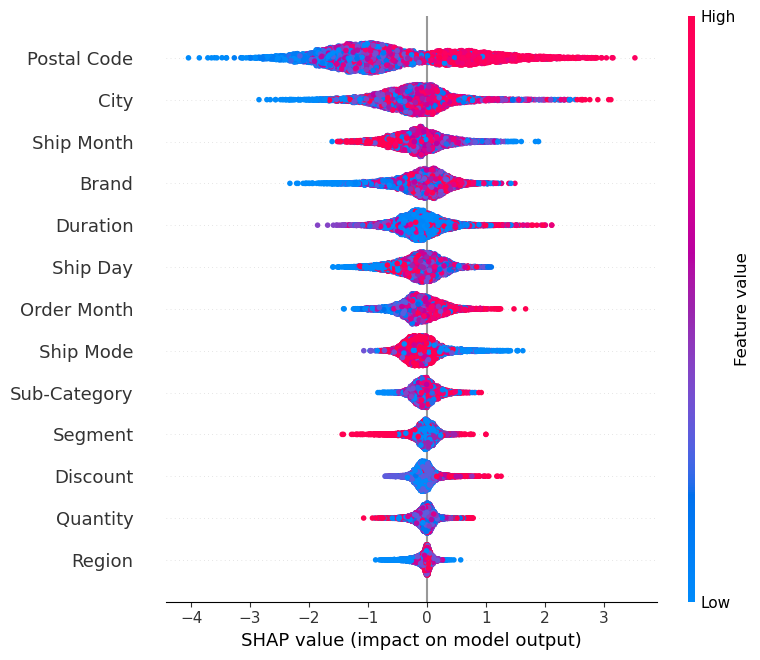

In [23]:
X = target.drop(columns=['Returned'])
y = target['Returned']
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
XGB_test=XGBClassifier(eval_metric='logloss', random_state=42)
XGB_test.fit(x_train,y_train)
y_pred = XGB_test.predict(x_test)
acu= accuracy_score(y_test,y_pred)
print("Accuracy",acu)
explainer = shap.TreeExplainer(XGB_test)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values,x_train)

In [ ]:
x_est,x_final,y_est,y_final = train_test_split(x_train,y_train,test_size=0.2,random_state=42,stratify =y_train )
def objective(trial):
    params = {
        'n_estimators': trial.suggest_categorical('n_estimators', [100,350]),
        'max_depth': trial.suggest_categorical('max_depth', [20,100]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.03,1.0]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
        'eval_metric': 'logloss',
        'random_state': 42
    }

    XGB_optuna = XGBClassifier(**params)
    XGB_optuna.fit(x_est, y_est,
             eval_set=[(x_final,y_final)],
             verbose = False)
    y_pred = XGB_optuna.predict(x_final)
    accuracy = accuracy_score(y_final, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=250)

print("Accuracy:", study.best_value)
print("Best Parameters:", study.best_params)

Accuracy:  0.9514757378689345


<function matplotlib.pyplot.show(close=None, block=None)>

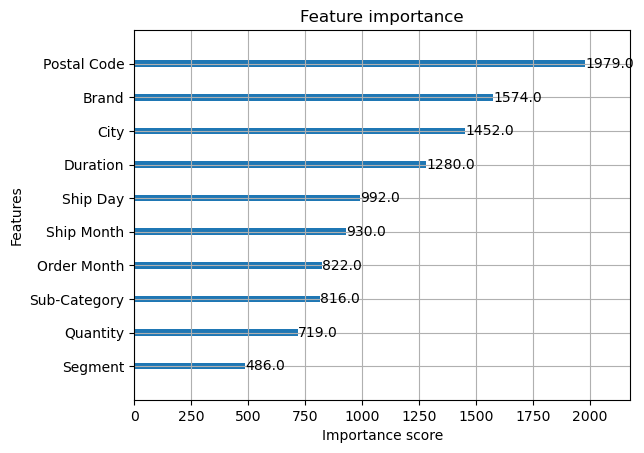

In [24]:
XGB_final = XGBClassifier(
    n_estimators=250,
    max_depth=25,
    learning_rate=0.3,
    eval_metric='logloss',
    random_state=42,
)
XGB_final.fit(x_train,y_train,
       eval_set =[(x_test,y_test)],
       verbose = False)
y_pred = XGB_final.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("Accuracy: ",acc)
plot_importance(XGB_final,max_num_features=10,importance_type='weight')
plt.show

XGBoost Accuracy:  0.9564782391195598

In [58]:
lgbm_param={
    'n_estimators': [100, 300],
    'learning_rate': [0.01, 0.1],
    'max_depth': [4, 6, 8],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20],
    'subsample': [0.8, 1.0]
}

LGBM_model=LGBMClassifier(random_seed=42)
lgbm_grid=GridSearchCV(
    estimator=LGBM_model,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    param_grid=lgbm_param
)
lgbm_grid.fit(x_train,y_train)
print('Best Params: ',lgbm_grid.best_params_)

C:\Users\hp\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Params:  {'learning_rate': 0.1, 'max_depth': 8, 'min_child_samples': 10, 'n_estimators': 300, 'num_leaves': 63, 'subsample': 0.8}


In [57]:
LGBM=LGBMClassifier(
    verbose=-1,
    random_seed=42,
    learning_rate=0.21,
    max_depth=11,
    min_child_samples=10,
    n_estimators=370,
    num_leaves=60,
    subsample=0.7
)
LGBM.fit(x_train,y_train)
y_pred_Lgbm=LGBM.predict(x_test)
acc_LGBM=accuracy_score(y_test,y_pred_Lgbm)
print("Accuracy:",acc_LGBM)

Accuracy: 0.9609804902451226


LightBGM Score: 0.9609804902451226

In [56]:
rf_params={
    'n_estimators':[100,300],
    'max_depth':[10,20,None],
    'min_samples_split':[2,5],
    'min_samples_leaf':[1,2],
    'bootstrap':[True,False]
}
rf_search=RandomForestClassifier(random_state=42)
rf_best=GridSearchCV(rf_search,rf_params,cv=3,scoring='accuracy',n_jobs=-1)
rf_best.fit(x_train,y_train)
print("Random Forest: ",rf_best.best_params_)

Random Forest:  {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [28]:
RF_model = RandomForestClassifier(
    random_state=42,
    bootstrap=False, 
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=3,
    n_estimators=100,
    criterion = 'gini'
)
RF_model.fit(x_train,y_train)

y_pred_RF= RF_model.predict(x_test)
acc_RF=accuracy_score(y_test,y_pred_RF)
print("Accuracy",acc_RF)

Accuracy 0.951975987993997


Random Forest Accuracy 0.951975987993997

In [55]:
cat_param_grid = {
    'iterations':[100,300],
    'depth':[4,6,8],
    'learning_rate':[0.01,0.1],
    'border_count':[32,64],
    'verbose':[0]
}
CAT_model = CatBoostClassifier(random_seed=42)
CAT_grid=GridSearchCV(
    estimator=CAT_model,
    param_grid=cat_param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=1
)
CAT_grid.fit(x_train,y_train)
print("Best Case: ",CAT_grid.best_params_)

CATB = CatBoostClassifier(random_seed=42,
                          border_count=32,
                          depth=9,
                          iterations=270,
                          learning_rate=0.73,
                          verbose=0
                         )
CATB.fit(x_train,y_train)
y_pred=CATB.predict(x_test)
acc_CAT=accuracy_score(y_pred,y_test)
print('CATBoost Accuracy: ',acc_CAT)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Case:  {'border_count': 32, 'depth': 8, 'iterations': 300, 'learning_rate': 0.1, 'verbose': 0}
CATBoost Accuracy:  0.9564782391195598


In [30]:
CATB = CatBoostClassifier(random_seed=42,
                          border_count=32,
                          depth=9,
                          iterations=270,
                          learning_rate=0.73,
                          verbose=0
                         )
CATB.fit(x_train,y_train)
y_pred=CATB.predict(x_test)
acc_CAT=accuracy_score(y_pred,y_test)
print('CATBoost Accuracy: ',acc_CAT)

CATBoost Accuracy:  0.9564782391195598


CATBoost Accuracy:  0.9564782391195598

In [46]:
base_learners=[
    ('RF',RandomForestClassifier(
        random_state=42,
        bootstrap=False, 
        max_depth=None,
        min_samples_leaf=1,
        min_samples_split=3,
        n_estimators=100,
        criterion = 'gini'
    )),
    ('XGB',XGBClassifier(
         n_estimators = 250, 
        max_depth= 25, 
        learning_rate= 0.3, 
        eval_metric='error',
        random_state=42,
        booster='gbtree'
    )),
    ('CB',CatBoostClassifier(
        verbose=0,
        iterations=300,
        random_seed=42,
        border_count=32,
        learning_rate=0.73,
        depth=9
    )),
    ('LGBM',LGBMClassifier(
        verbose=-1,
        random_seed=42,
        learning_rate=0.21,
        max_depth=11,
        min_child_samples=10,
        n_estimators=370,
        num_leaves=60,
        subsample=0.7
    ))
]
meta_learner=LGBMClassifier(
    random_seed=42,
    n_estimators=150,
    max_depth=3,
    learning_rate=0.07,
    num_leaves=12,
    subsample=0.7,
    min_child_samples=8
)

stack_model=StackingClassifier(
    estimators=base_learners,
    final_estimator=meta_learner,
    cv=3,
    n_jobs=-1,
    passthrough=True
)
stack_model.fit(x_train,y_train)
y_pred=stack_model.predict(x_test)
acc_stack=accuracy_score(y_test,y_pred)
print("Accuracy Stack: ",acc_stack)

Accuracy Stack:  0.9629814907453726


Accuracy Stack XGB:  0.9634817408704353
meta_learner=XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=5,
    learning_rate=0.33
)

Accuracy Stack: 0.9644822411205602
meta_learner=LGBMClassifier(
    random_seed=42,
    n_estimators=150,
    max_depth=3,
    learning_rate=0.07,
    num_leavs=15,
    subsample=0.7,
    min_child_samples=8
)


In [54]:
cross_val = cross_val_score(stack_model, X, y, cv=5, scoring='accuracy')
print(f"Accuracy: {cross_val.mean():.4f} ± {cross_val.std():.4f}")

Accuracy: 0.9187 ± 0.0015
